In [ ]:
## Testing multiple neural net architectures on time series data 

In [1]:
#Import necessary libraries

import pandas as pd
import numpy as np
from scipy import signal
import os
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import pickle as pkl
import itertools 
import glob
from sklearn import svm 
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import StratifiedShuffleSplit, GridSearchCV, cross_val_score
from sklearn.metrics import classification_report, confusion_matrix, plot_confusion_matrix, f1_score
from sklearn.decomposition import PCA
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier

%matplotlib inline 
# %matplotlib qt


In [2]:
#Importing raw data files 

#.csv paths
csvdir = "C:/Users/Wu Di/Documents/EEG-analysis/200108-Readings-csv/"
classical_csvpath = csvdir + "classical-music.csv"
hiphop_csvpath = csvdir + "hip-hop.csv"
whitenoise_csvpath = csvdir + "white-noise.csv"

#Read .csv files
cols_to_use = list(range(3, 35))

#Raw dataframes - each channel is a column
classical_df = pd.read_csv(classical_csvpath, header=None, usecols=cols_to_use)
hiphop_df = pd.read_csv(hiphop_csvpath, header=None, usecols=cols_to_use)
whitenoise_df = pd.read_csv(whitenoise_csvpath, header=None, usecols=cols_to_use)

In [242]:
#Bandpass (BP) filter helper functions

#Creates butterworth BP filter
def butter_bandpass(lowcut, highcut, fs, order=5):
    nyq = 0.5*fs  # Nyquist frequency, which is half of fs
    low = lowcut/nyq  # Digital butterworth filter cutoffs must be normalized to Nyquist frequency
    high = highcut/nyq
    b, a = signal.butter(order, [low, high], btype="bandpass")
    return b, a

def butter_lowpass(cutFreq,fs,order=5):
    nyq = 0.5*fs
    cutFreq = cutFreq/nyq
    b,a = signal.butter(order,cutFreq,btype="lowpass")
    return b,a 

def butter_highpass(cutFreq,fs,order=5):
    nyq = 0.5*fs
    cutFreq = cutFreq/nyq
    b,a = signal.butter(order,cutFreq,btype="highpass")
    return b,a 

#Applies butterworth BP filter
def butter_bandpass_filter(data, lowcut, highcut, fs, order=5):
    b, a = butter_bandpass(lowcut, highcut, fs, order=order)
#     filtered_data = signal.lfilter(b, a, data)
    filtered_data = signal.filtfilt(b,a,data)
    return filtered_data

#Applies butterworth lowpass filter
def butter_lowpass_filter(data, cutFreq, fs, order=5):
    b, a = butter_lowpass(cutFreq,fs,order=5)
    filtered_data = signal.filtfilt(b,a,data)
    return filtered_data

#Applies butterworth lowpass filter
def butter_highpass_filter(data, cutFreq, fs, order=5):
    b, a = butter_highpass(cutFreq,fs,order=5)
    filtered_data = signal.filtfilt(b,a,data)
    return filtered_data

#Applies butterworth BP filter to Pandas dataframe 
def bp_filter_df(df, lowcut, highcut, fs, order):
    rows, cols = df.shape  # Get no. of rows and cols in df
    new_index = range(1, rows+1)
    new_cols = range(1, cols+1)
    # Create new df with same no. of rows and cols
    new_df = pd.DataFrame(index=new_index, columns=new_cols)
    # new_df = new_df.fillna(0) #Fill in 0 for all values
    for i in range(cols):  # Apply bp filter each column (channel) and saves in new_df
        filt_col = butter_bandpass_filter(
            df.iloc[:, i].values, lowcut, highcut, fs, order)
        new_df[i+1] = filt_col
    return new_df

#Applies butterworth lowpass filter to Pandas dataframe 
def lp_filter_df(df, cutFreq, fs, order):
    rows, cols = df.shape  # Get no. of rows and cols in df
    new_index = range(1, rows+1)
    new_cols = range(1, cols+1)
    # Create new df with same no. of rows and cols
    new_df = pd.DataFrame(index=new_index, columns=new_cols)
    # new_df = new_df.fillna(0) #Fill in 0 for all values
    for i in range(cols):  # Apply bp filter each column (channel) and saves in new_df
        filt_col = butter_lowpass_filter(
            df.iloc[:, i].values, cutFreq, fs, order)
        new_df[i+1] = filt_col
    return new_df

In [243]:
filt_classical_df = lp_filter_df(classical_df,40.5,128,6)
filt_hiphop_df = lp_filter_df(hiphop_df,40.5,128,6)
filt_whitenoise_df = lp_filter_df(whitenoise_df,40.5,128,6)

In [14]:
#Splits a single dataframe into list of equally sized arrays
#Each element in list is nx32 array, where n= sample length 
def split_df(df,fs,sample_t,check=False):
    rows,_ = df.shape #get no. of rows
    sample_len = int(sample_t*fs) #find no. of recorded samples required for each sample time length
    Ns = int(rows/sample_len) #find total no. of samples
    df_cut = df.iloc[:Ns*sample_len] #truncate dataframe to exact multiple of sample length
    # print(Ns*sample_len)
    # print(Ns)
    df_split_list = np.vsplit(df_cut,Ns) #split dataframe row-wise, returns a list
    
    if check:
        print("Total no. of recorded samples: "+str(rows))
        print("Sample length: "+str(sample_len))
        print("Total no. of samples: "+str(Ns))
        print("Length of df_split_list: "+str(len(df_split_list)))
        
        if all(isinstance(x.shape,tuple) for x in df_split_list):
            print("Shape of each element in df_split_list: "+str(df_split_list[0].shape))
        else:
            print("Shapes are wrong.")
            for x in df_split_list:
                print(x.shape)
    return df_split_list,Ns

#Apply split_df() function to list of dataframes, reshape dataframe such that each element is an array 
#for the appropriate sample time length 
def split_bands_list(bands_list,fs,sample_t,check=False,checkSD=False):
    df_list_rFE = [0]*len(bands_list) #dataframes list ready for feature extraction 
    for df_no in range(len(bands_list)):
        df_split_list,Ns = split_df(bands_list[df_no],fs,sample_t,check=checkSD)
        list_of_series = [0]*Ns
        for i in range(len(df_split_list)):
            #New dataframe will have shape Nsx32, each element is a 1xsample_len array 
            new_row = [0]*32 
            #Each df_split_list[i] is a dataframe
            for j in range(len(df_split_list[i].columns)):
                new_row[j] = df_split_list[i].iloc[:,j].values 
            list_of_series[i] = new_row
        df_list_rFE[df_no] = pd.DataFrame(list_of_series)
    if check:
        print("Length of bands_list: "+str(len(bands_list)))
        print("Length of df_list_rFE: "+str(len(df_list_rFE)))
        if (all(isinstance(x.shape,tuple) for x in df_list_rFE)) and (Ns==len(df_list_rFE[0].index)):
            print("Shape of each dataframe in df_list_rFE: "+str(df_list_rFE[0].shape))
    return df_list_rFE
            

In [244]:
# #0.05s 
# split005_c_df=split_bands_list([classical_df],128,0.05)[0]
# split005_h_df=split_bands_list([hiphop_df],128,0.05)[0]
# split005_w_df=split_bands_list([whitenoise_df],128,0.05)[0]

# #0.1s 
# split01_c_df=split_bands_list([classical_df],128,0.1)[0]
# split01_h_df=split_bands_list([hiphop_df],128,0.1)[0]
# split01_w_df=split_bands_list([whitenoise_df],128,0.1)[0]


# #0.05s filt
# fsplit005_c_df=split_bands_list([filt_classical_df],128,0.05)[0]
# fsplit005_h_df=split_bands_list([filt_hiphop_df],128,0.05)[0]
# fsplit005_w_df=split_bands_list([filt_whitenoise_df],128,0.05)[0]

# #0.1s filt
# fsplit01_c_df=split_bands_list([filt_classical_df],128,0.1)[0]
# fsplit01_h_df=split_bands_list([filt_hiphop_df],128,0.1)[0]
# fsplit01_w_df=split_bands_list([filt_whitenoise_df],128,0.1)[0]

In [245]:
# print(split005_c_df.shape)
# print(split005_h_df.shape)
# print(split005_w_df.shape)

# print(split01_c_df.shape)
# print(split01_h_df.shape)
# print(split01_w_df.shape)

# print(fsplit005_c_df.shape)
# print(fsplit005_h_df.shape)
# print(fsplit005_w_df.shape)

# print(fsplit01_c_df.shape)
# print(fsplit01_h_df.shape)
# print(fsplit01_w_df.shape)

(1021, 32)
(1279, 32)
(989, 32)
(510, 32)
(639, 32)
(494, 32)


In [246]:
# #Save datasets
# split005_c_df.to_pickle("F:\EEG-data\music\\raw\\0.05s/raw_classical.pkl")
# split005_h_df.to_pickle("F:\EEG-data\music\\raw\\0.05s/raw_hiphop.pkl")
# split005_w_df.to_pickle("F:\EEG-data\music\\raw\\0.05s/raw_whitenoise.pkl")

# split01_c_df.to_pickle("F:\EEG-data\music\\raw\\0.1s/raw_classical.pkl")
# split01_h_df.to_pickle("F:\EEG-data\music\\raw\\0.1s/raw_hiphop.pkl")
# split01_w_df.to_pickle("F:\EEG-data\music\\raw\\0.1s/raw_whitenoise.pkl")

# Filt 
# fsplit005_c_df.to_pickle("F:\EEG-data\music\\filtered\\0.05s/lp40.5_classical.pkl")
# fsplit005_h_df.to_pickle("F:\EEG-data\music\\filtered\\0.05s/lp40.5_hiphop.pkl")
# fsplit005_w_df.to_pickle("F:\EEG-data\music\\filtered\\0.05s/lp40.5_whitenoise.pkl")

# fsplit01_c_df.to_pickle("F:\EEG-data\music\\filtered\\0.1s/lp40.5_classical.pkl")
# fsplit01_h_df.to_pickle("F:\EEG-data\music\\filtered\\0.1s/lp40.5_hiphop.pkl")
# fsplit01_w_df.to_pickle("F:\EEG-data\music\\filtered\\0.1s/lp40.5_whitenoise.pkl")

In [20]:
# #0.05s 
# c_df005 = pd.read_pickle("F:\EEG-data\music\\raw\\0.05s/raw_classical.pkl")
# h_df005 = pd.read_pickle("F:\EEG-data\music\\raw\\0.05s/raw_hiphop.pkl")
# w_df005 = pd.read_pickle("F:\EEG-data\music\\raw\\0.05s/raw_whitenoise.pkl")

# #0.1s
# c_df01 = pd.read_pickle("F:\EEG-data\music\\raw\\0.1s/raw_classical.pkl")
# h_df01 = pd.read_pickle("F:\EEG-data\music\\raw\\0.1s/raw_hiphop.pkl")
# w_df01 = pd.read_pickle("F:\EEG-data\music\\raw\\0.1s/raw_whitenoise.pkl") 

In [2]:
#0.05s 
fc_df005 = pd.read_pickle("F:\EEG-data\music\\filtered\\0.05s/lp40.5_classical.pkl")
fh_df005 = pd.read_pickle("F:\EEG-data\music\\filtered\\0.05s/lp40.5_hiphop.pkl")
fw_df005 = pd.read_pickle("F:\EEG-data\music\\filtered\\0.05s/lp40.5_whitenoise.pkl")

#0.1s
fc_df01 = pd.read_pickle("F:\EEG-data\music\\filtered\\0.1s/lp40.5_classical.pkl")
fh_df01 = pd.read_pickle("F:\EEG-data\music\\filtered\\0.1s/lp40.5_hiphop.pkl")
fw_df01 = pd.read_pickle("F:\EEG-data\music\\filtered\\0.1s/lp40.5_whitenoise.pkl") 

In [3]:
# print(c_df005.shape)
# print(h_df005.shape)
# print(w_df005.shape)

# print(c_df01.shape)
# print(h_df01.shape)
# print(w_df01.shape)

print(fc_df005.shape)
print(fh_df005.shape)
print(fw_df005.shape)

print(fc_df01.shape)
print(fh_df01.shape)
print(fw_df01.shape)

(1021, 32)
(1279, 32)
(989, 32)
(510, 32)
(639, 32)
(494, 32)


In [3]:
# Shape each dataframe into 320,12,32
def reshape_df(df):
    sampLen = len(df.iloc[0,0])
    N = df.shape[0]
    new_df = np.zeros((N,sampLen,32))
    for i in range(32):
        channel = df.iloc[:,i].values 
        channel_df = np.zeros((N,sampLen))
        for j in range(len(channel)):
            channel_df[j,:] = channel[j]
        new_df[:,:,i] = keras.utils.normalize(channel_df)
    return new_df


In [4]:
# #0.05s
# c_df005r = reshape_df(c_df005)
# h_df005r = reshape_df(h_df005)
# w_df005r = reshape_df(w_df005)

# #0.1s
# c_df01r = reshape_df(c_df01)
# h_df01r = reshape_df(h_df01)
# w_df01r = reshape_df(w_df01)

#Filtered
#0.05s
fc_df005r = reshape_df(fc_df005)
fh_df005r = reshape_df(fh_df005)
fw_df005r = reshape_df(fw_df005)

#0.1s
fc_df01r = reshape_df(fc_df01)
fh_df01r = reshape_df(fh_df01)
fw_df01r = reshape_df(fw_df01)

In [5]:
# #0.05s
# print(c_df005r.shape)
# print(h_df005r.shape)
# print(w_df005r.shape)

# #0.1s
# print(c_df01r.shape)
# print(h_df01r.shape)
# print(w_df01r.shape)

##Filtered
#0.05s
print(fc_df005r.shape)
print(fh_df005r.shape)
print(fw_df005r.shape)

#0.1s
print(fc_df01r.shape)
print(fh_df01r.shape)
print(fw_df01r.shape)
 

(1021, 6, 32)
(1279, 6, 32)
(989, 6, 32)
(510, 12, 32)
(639, 12, 32)
(494, 12, 32)


In [88]:
#0.05
X005 = np.vstack((c_df005r,h_df005r,w_df005r))
y005 = np.hstack((np.zeros(c_df005r.shape[0]),np.ones(h_df005r.shape[0]),2*np.ones(w_df005r.shape[0])))
print(X005.shape)
print(y005.shape)
#0.1
X01 = np.vstack((c_df01r,h_df01r,w_df01r))
y01 = np.hstack((np.zeros(c_df01r.shape[0]),np.ones(h_df01r.shape[0]),2*np.ones(w_df01r.shape[0])))
print(X01.shape)
print(y01.shape)

(3289, 6, 32)
(3289,)
(1643, 12, 32)
(1643,)


In [6]:
## FILTERED

#0.05
fX005 = np.vstack((fc_df005r,fh_df005r,fw_df005r))
fy005 = np.hstack((np.zeros(fc_df005r.shape[0]),np.ones(fh_df005r.shape[0]),2*np.ones(fw_df005r.shape[0])))
print(fX005.shape)
print(fy005.shape)
#0.1
fX01 = np.vstack((fc_df01r,fh_df01r,fw_df01r))
fy01 = np.hstack((np.zeros(fc_df01r.shape[0]),np.ones(fh_df01r.shape[0]),2*np.ones(fw_df01r.shape[0])))
print(fX01.shape)
print(fy01.shape)

(3289, 6, 32)
(3289,)
(1643, 12, 32)
(1643,)


In [7]:
#Split into train and test sets
def split_train_test(X,y):
    sss = StratifiedShuffleSplit(n_splits=5,test_size=0.2,random_state=0)
    for train_index, test_index in sss.split(X,y):
                x_train, x_test = X[train_index],X[test_index]
                y_train, y_test = y[train_index],y[test_index]
    return x_train,x_test,y_train,y_test

In [89]:
#0.05s
x_train005,x_test005,y_train005,y_test005 = split_train_test(X005,y005)
#0.1s
x_train01,x_test01,y_train01,y_test01 = split_train_test(X01,y01)

In [8]:
# FILTERED
#0.05s
fx_train005,fx_test005,fy_train005,fy_test005 = split_train_test(fX005,fy005)
#0.1s
fx_train01,fx_test01,fy_train01,fy_test01 = split_train_test(fX01,fy01)

In [9]:
#DNN model
def DNN_model(sampLen):
    model = tf.keras.models.Sequential([
        tf.keras.layers.Dense(sampLen*32, input_shape = (sampLen,32), activation="relu"),
        tf.keras.layers.Flatten(), 
        tf.keras.layers.Dense(10, activation="relu"), 
        tf.keras.layers.Dense(3,activation="softmax")
    ])
    model.compile(loss="sparse_categorical_crossentropy",
                optimizer='adam',
                metrics=["accuracy"])
    # model.summary()
    return model

#Conv model
def CONV_model(sampLen):
    model2 = tf.keras.models.Sequential([
        tf.keras.layers.Conv1D(filters=128, kernel_size=5,strides=1, padding="causal",
                                activation="relu",input_shape=(sampLen,32)), #input shape = (n_timesteps,n_features)
        tf.keras.layers.Conv1D(filters=64, kernel_size=5,strides=1, padding="causal",activation="relu"),
        tf.keras.layers.Conv1D(filters=32, kernel_size=5,strides=1, padding="causal",activation="relu"),
        # tf.keras.layers.Dropout(0.5),
        tf.keras.layers.MaxPool1D(pool_size=2),
        tf.keras.layers.Conv1D(filters=16, kernel_size=5,strides=1, padding="causal",activation="relu"),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(10, activation="relu"), 
        # tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Dense(3,activation="softmax")
    ])
    # optimizer = tf.keras.optimizers.Adam(lr=9e-4)
    model2.compile(loss="sparse_categorical_crossentropy",
                optimizer="adam",
                metrics=["accuracy"])
    return model2

#Conv + LSTM
def CONV_LSTM_model(sampLen):
    model3 = tf.keras.models.Sequential([
    tf.keras.layers.Conv1D(filters=128, kernel_size=5,strides=1, padding="causal",
                              activation="relu",input_shape=(sampLen,32)), #input shape = (n_timesteps,n_features)
    tf.keras.layers.Conv1D(filters=64, kernel_size=5,strides=1, padding="causal",activation="relu"),
    tf.keras.layers.Conv1D(filters=32, kernel_size=5,strides=1, padding="causal",activation="relu"),
    # tf.keras.layers.Dropout(0.5),
    tf.keras.layers.MaxPool1D(pool_size=2),
    tf.keras.layers.Conv1D(filters=16, kernel_size=5,strides=1, padding="causal",activation="relu"),
    # tf.keras.layers.Flatten(),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32, return_sequences=True)),
    tf.keras.layers.Flatten(),
    # tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32, return_sequences=True)),
    tf.keras.layers.Dense(10, activation="relu"), 
    # tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(3,activation="softmax")
])
    model3.compile(loss="sparse_categorical_crossentropy",
              optimizer='adam',
              metrics=["accuracy"])
    return model3

#Simple RNN 
def RNN_model(sampLen):
    model4 = tf.keras.models.Sequential([
    tf.keras.layers.SimpleRNN(40, input_shape = (sampLen,32),return_sequences=True),
    tf.keras.layers.SimpleRNN(40),
    # tf.keras.layers.Dense(10,activation="relu",input_shape=(12,32)),
    tf.keras.layers.Dense(3,activation="softmax"),
    ])
    model4.compile(loss="sparse_categorical_crossentropy",
                optimizer='adam',
                metrics=["accuracy"])
    return model4

#LSTM only

def LSTM_model(sampLen):
    model5 = tf.keras.models.Sequential([
    # tf.keras.layers.Flatten(input_shape=(sampLen,32)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32, return_sequences=True,input_shape=(sampLen,32))),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32, return_sequences=True)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(10,activation="relu"),
    tf.keras.layers.Dense(3,activation="softmax"),
    ])
    model5.compile(loss="sparse_categorical_crossentropy",
                optimizer='adam',
                metrics=["accuracy"])
    return model5

In [174]:
# 0.05s 
dataset005 = tf.data.Dataset.from_tensor_slices((x_train005,y_train005))
devset005  = tf.data.Dataset.from_tensor_slices((x_test005,y_test005))
dataset005b = dataset005.batch(40)
devset005b = devset005.batch(40)

# 0.1s 
dataset01 = tf.data.Dataset.from_tensor_slices((x_train01,y_train01))
devset01  = tf.data.Dataset.from_tensor_slices((x_test01,y_test01))
dataset01b = dataset01.batch(40)
devset01b = devset01.batch(40)

In [12]:
#FILTERED
# 0.05s 
fdataset005 = tf.data.Dataset.from_tensor_slices((fx_train005,fy_train005))
fdevset005  = tf.data.Dataset.from_tensor_slices((fx_test005,fy_test005))
fdataset005b = fdataset005.batch(40)
fdevset005b = fdevset005.batch(40)

# 0.1s 
fdataset01 = tf.data.Dataset.from_tensor_slices((fx_train01,fy_train01))
fdevset01  = tf.data.Dataset.from_tensor_slices((fx_test01,fy_test01))
fdataset01b = fdataset01.batch(40)
fdevset01b = fdevset01.batch(40)

In [10]:
def test(model,dataset,devset,batchsize,epochs):
    tf.random.set_seed(10)
    datasetb = dataset.batch(batchsize)
    devsetb = devset.batch(batchsize)
    history = model.fit(datasetb,epochs=epochs,verbose=0,validation_data=devsetb)
    return history 

In [226]:
# 0.05s 
# Testing different models, epochs=10, batchsize = 1 
sampLen = 6 
DNN_model005 = DNN_model(sampLen)
CONV_model005 = CONV_model(sampLen)
CONV_LSTM_model005 = CONV_LSTM_model(sampLen)
LSTM_model005 = LSTM_model(sampLen)
RNN_model005 = RNN_model(sampLen)
#Histories 
DNN_hist005 = test(DNN_model005,dataset005,devset005,1,10)
CONV_hist005 = test(CONV_model005,dataset005,devset005,1,10)
CONV_LSTM_hist005 = test(CONV_LSTM_model005,dataset005,devset005,1,10)
LSTM_hist005 = test(LSTM_model005,dataset005,devset005,1,10)
RNN_hist005 = test(RNN_model005,dataset005,devset005,1,10)
#Max validation accuracy 
valacc_DNN005 = max(DNN_hist005.history['val_accuracy'])
valacc_CONV005 = max(CONV_hist005.history['val_accuracy'])
valacc_CONVLSTM005 = max(CONV_LSTM_hist005.history['val_accuracy'])
valacc_LSTM005 = max(LSTM_hist005.history['val_accuracy'])
valacc_RNN005 = max(RNN_hist005.history['val_accuracy'])

print(valacc_DNN005)
print(valacc_CONV005)
print(valacc_CONVLSTM005)
print(valacc_LSTM005)
print(valacc_RNN005)


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

0.9924012422561646
0.9954407215118408
0.9878419637680054
0.9924012422561646
0.975683867931366


In [18]:
#### FILTERED ####
# 0.05s 
# Testing different models, epochs=10, batchsize = 1 
sampLen = 6 
DNN_model005 = DNN_model(sampLen)
CONV_model005 = CONV_model(sampLen)
CONV_LSTM_model005 = CONV_LSTM_model(sampLen)
LSTM_model005 = LSTM_model(sampLen)
RNN_model005 = RNN_model(sampLen)
#Histories 
DNN_hist005f = test(DNN_model005,fdataset005,fdevset005,1,10)
CONV_hist005f = test(CONV_model005,fdataset005,fdevset005,1,10)
CONV_LSTM_hist005f = test(CONV_LSTM_model005,fdataset005,fdevset005,1,10)
LSTM_hist005f = test(LSTM_model005,fdataset005,fdevset005,1,10)
RNN_hist005f = test(RNN_model005,fdataset005,fdevset005,1,10)
#Max validation accuracy 
valacc_DNN005f = max(DNN_hist005f.history['val_accuracy'])
valacc_CONV005f = max(CONV_hist005f.history['val_accuracy'])
valacc_CONVLSTM005f = max(CONV_LSTM_hist005f.history['val_accuracy'])
valacc_LSTM005f = max(LSTM_hist005f.history['val_accuracy'])
valacc_RNN005f = max(RNN_hist005f.history['val_accuracy'])

print("Filtered validation accuracies")
print(valacc_DNN005f)
print(valacc_CONV005f)
print(valacc_CONVLSTM005f)
print(valacc_LSTM005f)
print(valacc_RNN005f)


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

Filtered validation accuracies
0.9924012422561646
0.9924012422561646
0.9878419637680054
0.9939209818840027
0.9772036671638489


In [227]:
# 0.1s 
# Testing different models, epochs=10, batchsize = 1 
sampLen = 12
DNN_model01 = DNN_model(sampLen)
CONV_model01 = CONV_model(sampLen)
CONV_LSTM_model01 = CONV_LSTM_model(sampLen)
LSTM_model01 = LSTM_model(sampLen)
RNN_model01 = RNN_model(sampLen)
#Histories 
DNN_hist01 = test(DNN_model01,dataset01,devset01,1,10)
CONV_hist01 = test(CONV_model01,dataset01,devset01,1,10)
CONV_LSTM_hist01 = test(CONV_LSTM_model01,dataset01,devset01,1,10)
LSTM_hist01 = test(LSTM_model01,dataset01,devset01,1,10)
RNN_hist01 = test(RNN_model01,dataset01,devset01,1,10)
#Max validation accuracy 
valacc_DNN01 = max(DNN_hist01.history['val_accuracy'])
valacc_CONV01 = max(CONV_hist01.history['val_accuracy'])
valacc_CONVLSTM01 = max(CONV_LSTM_hist01.history['val_accuracy'])
valacc_LSTM01 = max(LSTM_hist01.history['val_accuracy'])
valacc_RNN01 = max(RNN_hist01.history['val_accuracy'])

print(valacc_DNN01)
print(valacc_CONV01)
print(valacc_CONVLSTM01)
print(valacc_LSTM01)
print(valacc_RNN01)


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

1.0
0.996960461139679
0.9817629456520081
0.996960461139679
0.9665653705596924


In [15]:
##### FILTERED ########
#0.1s
# Testing different models, epochs=10, batchsize = 1 
sampLen = 12
DNN_model01 = DNN_model(sampLen)
CONV_model01 = CONV_model(sampLen)
CONV_LSTM_model01 = CONV_LSTM_model(sampLen)
LSTM_model01 = LSTM_model(sampLen)
RNN_model01 = RNN_model(sampLen)
#Histories 
DNN_hist01f = test(DNN_model01,fdataset01,fdevset01,1,10)
CONV_hist01f = test(CONV_model01,fdataset01,fdevset01,1,10)
CONV_LSTM_hist01f = test(CONV_LSTM_model01,fdataset01,fdevset01,1,10)
LSTM_hist01f = test(LSTM_model01,fdataset01,fdevset01,1,10)
RNN_hist01f = test(RNN_model01,fdataset01,fdevset01,1,10)
#Max validation accuracy 
valacc_DNN01f = max(DNN_hist01f.history['val_accuracy'])
valacc_CONV01f = max(CONV_hist01f.history['val_accuracy'])
valacc_CONVLSTM01f = max(CONV_LSTM_hist01f.history['val_accuracy'])
valacc_LSTM01f = max(LSTM_hist01f.history['val_accuracy'])
valacc_RNN01f = max(RNN_hist01f.history['val_accuracy'])

print("Filtered validation accuracies")
print(valacc_DNN01f)
print(valacc_CONV01f)
print(valacc_CONVLSTM01f)
print(valacc_LSTM01f)
print(valacc_RNN01f)


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

Filtered validation accuracies
1.0
0.996960461139679
0.9908814430236816
1.0
0.975683867931366


In [232]:
# Testing different batch sizes 
def test_batchsizes(model,dataset,devset,batchsizes,epochs):
    histories = []
    for batchsize in batchsizes:
        histories.append(test(model,dataset,devset,batchsize,epochs))
    return histories 

In [233]:
# 0.1s 
batchsizes = list(range(1,40,10))

DNN01_histories = test_batchsizes(DNN_model01,dataset01,devset01,batchsizes,10)
CONV01_histories = test_batchsizes(CONV_model01,dataset01,devset01,batchsizes,10)
CONV_LSTM_01_histories = test_batchsizes(CONV_LSTM_model01,dataset01,devset01,batchsizes,10)
LSTM_01_histories = test_batchsizes(LSTM_model01,dataset01,devset01,batchsizes,10)
RNN01_histories = test_batchsizes(RNN_model01,dataset01,devset01,batchsizes,10)

TypeError: 'list' object is not callable

In [240]:
hists_maxvalacc = lambda histories: max([history.history['val_accuracy'][-1] for history in histories])
hists_maxvalacc_batch = lambda histories,batchsizes: batchsizes[np.argmax(np.array([history.history['val_accuracy'][-1] for history in histories]))]

print("batch size: {}, val acc: {}".format(hists_maxvalacc_batch(DNN01_histories,batchsizes),hists_maxvalacc(DNN01_histories)))
print("batch size: {}, val acc: {}".format(hists_maxvalacc_batch(CONV01_histories,batchsizes),hists_maxvalacc(CONV01_histories)))
print("batch size: {}, val acc: {}".format(hists_maxvalacc_batch(CONV_LSTM_01_histories,batchsizes),hists_maxvalacc(CONV_LSTM_01_histories)))
print("batch size: {}, val acc: {}".format(hists_maxvalacc_batch(LSTM_01_histories,batchsizes),hists_maxvalacc(LSTM_01_histories)))
print("batch size: {}, val acc: {}".format(hists_maxvalacc_batch(RNN01_histories,batchsizes),hists_maxvalacc(RNN01_histories)))

batch size: 1, val acc: 0.996960461139679
batch size: 1, val acc: 1.0
batch size: 1, val acc: 0.996960461139679
batch size: 31, val acc: 0.9939209818840027
batch size: 1, val acc: 0.9848024249076843


In [ ]:
# FILTERED 0.1s 
batchsizes = list(range(1,40,10))

DNN01_historiesf = test_batchsizes(DNN_model01,dataset01f,devset01f,batchsizes,10)
CONV01_historiesf = test_batchsizes(CONV_model01,dataset01f,devset01f,batchsizes,10)
CONV_LSTM_01_historiesf = test_batchsizes(CONV_LSTM_model01f,dataset01f,devset01,batchsizes,10)
LSTM_01_historiesf = test_batchsizes(LSTM_model01,dataset01f,devset01f,batchsizes,10)
RNN01_historiesf = test_batchsizes(RNN_model01,dataset01f,devset01f,batchsizes,10)
    

In [ ]:
hists_maxvalacc = lambda histories: max([history.history['val_accuracy'][-1] for history in histories])
hists_maxvalacc_batch = lambda histories,batchsizes: batchsizes[np.argmax(np.array([history.history['val_accuracy'][-1] for history in histories]))]

print("batch size: {}, val acc: {}".format(hists_maxvalacc_batch(DNN01_historiesf,batchsizes),hists_maxvalacc(DNN01_histories)))
print("batch size: {}, val acc: {}".format(hists_maxvalacc_batch(CONV01_historiesf,batchsizes),hists_maxvalacc(CONV01_histories)))
print("batch size: {}, val acc: {}".format(hists_maxvalacc_batch(CONV_LSTM_01_historiesf,batchsizes),hists_maxvalacc(CONV_LSTM_01_histories)))
print("batch size: {}, val acc: {}".format(hists_maxvalacc_batch(LSTM_01_historiesf,batchsizes),hists_maxvalacc(LSTM_01_histories)))
print("batch size: {}, val acc: {}".format(hists_maxvalacc_batch(RNN01_historiesf,batchsizes),hists_maxvalacc(RNN01_histories)))

In [225]:
sampLen=12
model = DNN_model(sampLen)
history = model.fit(dataset01b,epochs=10,validation_data=devset01b)

Epoch 1/10
33/33 [==============================] - 0s 14ms/step - loss: 0.6764 - accuracy: 0.7633 - val_loss: 0.3098 - val_accuracy: 0.9362
Epoch 2/10
33/33 [==============================] - 0s 8ms/step - loss: 0.1943 - accuracy: 0.9551 - val_loss: 0.1162 - val_accuracy: 0.9666
Epoch 3/10
33/33 [==============================] - 0s 7ms/step - loss: 0.0797 - accuracy: 0.9840 - val_loss: 0.0659 - val_accuracy: 0.9939
Epoch 4/10
33/33 [==============================] - 0s 7ms/step - loss: 0.0424 - accuracy: 0.9962 - val_loss: 0.0453 - val_accuracy: 0.9939
Epoch 5/10
33/33 [==============================] - 0s 8ms/step - loss: 0.0261 - accuracy: 0.9992 - val_loss: 0.0351 - val_accuracy: 0.9939
Epoch 6/10
33/33 [==============================] - 0s 13ms/step - loss: 0.0174 - accuracy: 1.0000 - val_loss: 0.0296 - val_accuracy: 0.9939
Epoch 7/10
33/33 [==============================] - 0s 9ms/step - loss: 0.0124 - accuracy: 1.0000 - val_loss: 0.0262 - val_accuracy: 0.9939
Epoch 8/10
33/33 [

In [195]:
# 0.05s 
sampLen = 6
DNN_005_model = DNN_model(sampLen)
# DNN_005_model.fit(dataset005b,epochs=10,validation_data=devset005b)
DNN_005_history = test(DNN_005_model,dataset005,devset005,10,100)

Model: "sequential_67"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_4 (Conv1D)            (None, 6, 128)            20608     
_________________________________________________________________
conv1d_5 (Conv1D)            (None, 6, 64)             41024     
_________________________________________________________________
conv1d_6 (Conv1D)            (None, 6, 32)             10272     
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 3, 32)             0         
_________________________________________________________________
conv1d_7 (Conv1D)            (None, 3, 16)             2576      
_________________________________________________________________
flatten_30 (Flatten)         (None, 48)                0         
_________________________________________________________________
dense_190 (Dense)            (None, 10)              

KeyboardInterrupt: 

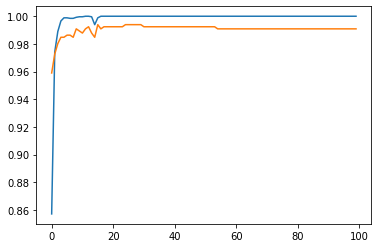

In [189]:
plt.plot(DNN_005_history.history["accuracy"])
plt.plot(DNN_005_history.history["val_accuracy"])

In [192]:
# 0.1s 
sampLen = 12
DNN_01_model = DNN_model(sampLen)
DNN_01_history = test(DNN_01_model,dataset01,devset01,1,10)

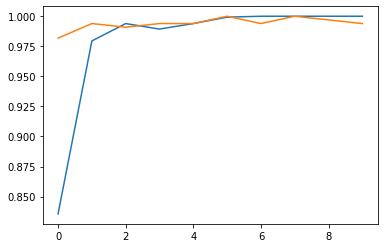

In [194]:
plt.plot(DNN_01_history.history["accuracy"])
plt.plot(DNN_01_history.history["val_accuracy"])

In [181]:
sampLen = 12
# model = tf.keras.models.Sequential([
#         tf.keras.layers.Flatten(input_shape=(12,32)),
#         # tf.keras.layers.Dense(sampLen*32, input_shape = (sampLen,32), activation="relu"),
#         # tf.keras.layers.Dense(sampLen*32,activation="relu"), 
#         tf.keras.layers.Dense(128, activation="relu"), 
#         tf.keras.layers.Dense(3,activation="softmax")
#         # tf.keras.layers.Dense(3)
#     ])
model = tf.keras.models.Sequential([
        tf.keras.layers.Dense(sampLen*32, input_shape = (sampLen,32), activation="relu"), 
        tf.keras.layers.Dense(10, activation="relu"), 
        tf.keras.layers.Dense(3,activation="softmax")
    ])
model.compile(loss="sparse_categorical_crossentropy",
            optimizer='adam',
            metrics=["accuracy"])
            
model.summary()

Model: "sequential_61"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_172 (Dense)            (None, 12, 384)           12672     
_________________________________________________________________
dense_173 (Dense)            (None, 12, 10)            3850      
_________________________________________________________________
dense_174 (Dense)            (None, 12, 3)             33        
Total params: 16,555
Trainable params: 16,555
Non-trainable params: 0
_________________________________________________________________


In [182]:
model.fit(x_train01,y_train01,epochs=10,validation_data=)
# model.fit(x_train01.reshape(1314,384),y_train01,epochs=10)
# model.fit(X01,y01,epochs=10)


Epoch 1/10


InvalidArgumentError:  assertion failed: [Condition x == y did not hold element-wise:] [x (sparse_categorical_crossentropy/SparseSoftmaxCrossEntropyWithLogits/Shape_1:0) = ] [32 1] [y (sparse_categorical_crossentropy/SparseSoftmaxCrossEntropyWithLogits/strided_slice:0) = ] [32 12]
	 [[node sparse_categorical_crossentropy/SparseSoftmaxCrossEntropyWithLogits/assert_equal_1/Assert/Assert (defined at <ipython-input-182-9a71af2f015a>:1) ]] [Op:__inference_train_function_29397]

Function call stack:
train_function


In [138]:
ANN_model = keras.Sequential([
# keras.layers.Flatten(input_shape=(8,32)),
keras.layers.Dense(384,input_dim=no_features,activation='relu'),
keras.layers.Dense(384/2, activation='relu'),
keras.layers.Dense(384/4, activation='relu'),
keras.layers.Dense(3,activation='softmax')])

ANN_model.compile(optimizer="adam",
            loss="categorical_crossentropy",
            metrics = ['accuracy'])


(1314,)

In [168]:
y_train01.reshape(-1,3)

array([[0., 0., 0.],
       [2., 2., 2.],
       [2., 1., 0.],
       ...,
       [0., 2., 2.],
       [0., 1., 0.],
       [1., 2., 0.]])